# Hierachical cluster odor spectra across animals

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys
import os
toplevelpath = os.path.realpath(os.path.pardir)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import glob, csv, pickle, os, json
import matplotlib, scipy
from collections import defaultdict, OrderedDict
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage,dendrogram
from matplotlib import gridspec

from regnmf import ImageAnalysisComponents as ia

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Prepare Analysis

#### Specify parameter

In [6]:
method = 'nnmf_150_sm2_convex_sp*_ios_meas' #'sica_200_ios_meas' #
animals =  ['111210sph', '111221sph','111222sph', '120107', '120119', '120121', '120125']
stimulusdrive = 0.4 # maximale trial2trial correlation distance (aka 1-correlation) of modes to be included
min_activation = 0.2 # maximale activation strength of modes to be included

datapath = os.path.join(toplevelpath, 'glomcentric_data_preprocessed')
factorization_path = os.path.join(datapath, 'MOBdecomposed')
bg_path = os.path.join(datapath, 'MOBconverted')
cas2name_file = os.path.join(datapath, 'DataDicts', 'Name2MomCas.tab')
cluster_file = os.path.join(datapath, 'DataDicts', 'cluster_assignment.json')
spec_savepath = os.path.join(datapath, 'DataDicts')
vis_path = os.path.join(datapath, 'Vis')
clustering_savepath = os.path.join(vis_path, 'Clustering') 


#### Define Functions to process hierachichal cluster (linkages)

In [7]:
def return_all_childs(mylinkage, parent):
    '''
    Recursive function returns all leafs of parent node in mylinkage.
    A leaf corresponds to the index of the object in the timeseries.'''    
    num_leaves = mylinkage.shape[0]+1
    parent = int(parent)
    if parent<num_leaves:
        return [parent]
    else:
        leftchild, rightchild = mylinkage[parent-num_leaves][:2]
        return return_all_childs(mylinkage, parent=leftchild) + return_all_childs(mylinkage, parent=rightchild)

def return_all_links(mylinkage, parent):
    ''' recursive function returns all links of parent node in mylinkage''' 
    num_leaves = mylinkage.shape[0]+1
    parent = int(parent)
    if parent<num_leaves:
        return [parent]
    else:
        leftchild, rightchild = mylinkage[parent-num_leaves][:2]
        return [parent] + return_all_links(mylinkage, parent=leftchild) + return_all_links(mylinkage, parent=rightchild)

def color_clusters(cluster, color_dict = None, chex=False):
    ''' creates link-coloring function to color each cluster (given by parent node) '''
    cluster_colors = defaultdict(lambda: '0.5')
    for clust_ix, cluster_parent in enumerate(cluster):
        clust_color = color_dict[cluster_parent] if color_dict else plt.cm.prism(1.*clust_ix/len(cluster)) 
        if not(chex):
            clust_color = matplotlib.colors.rgb2hex(clust_color)
        colordict_update = {i: clust_color for i in return_all_links(link, cluster_parent+link.shape[0]+1)}
        cluster_colors.update(colordict_update)
    return lambda node: cluster_colors[node]

#### Define function to create combined timeseries of all animals

In [8]:
def load_combined_series(allIDs, filemask, thres, min_strength, factorization_path):
    ''' function to load and preprocess timeseries of multiple animals '''
    
    allgood, turn = [], []
    for measID in allIDs:
        
        # load timeseries
        ts = ia.TimeSeries()
        filename = glob.glob(os.path.join(factorization_path, measID, filemask+'.npy'))
        assert len(filename)==1
        ts.load(filename[0].split('.')[0])
        ts.label_stimuli = [i.split('_')[0] for i in ts.label_stimuli]
        if '_l_' in ts.name: 
            turn.append(measID)
            ts.base.set_series(ts.base.shaped2D()[:,::-1])
        ts.name = measID
        
        # calc odor spectrum of modes
        signal = ia.TrialMean()(ia.CutOut((2, 5))(ts))        
        # calc t2t correlation, exclude modes with t2t < thres
        mode_cor = ia.CalcStimulusDrive()(signal)
        signal = ia.SelectObjects()(signal, mode_cor._series.squeeze()<thres)
        
        # calc single odor response
        signal = ia.SingleSampleResponse()(signal)
        
        # selected only modes with maximal activation above min_strength
        strength = np.max(signal._series,0)
        signal = ia.SelectObjects()(signal, strength>min_strength)
        
        allgood.append(signal)
        
    allgood = ia.ObjectConcat(unequalsample=True)(allgood)
    return allgood, turn

#### Read in data

In [9]:
cas2name = {l[0]:l[1] for l in csv.reader(open(cas2name_file),  delimiter='\t')}

ts, turn = load_combined_series(animals, method, stimulusdrive, min_activation, factorization_path)

# load background images, turn if left bulb
bg_dict = {measID: plt.imread(os.path.join(bg_path, measID, 'bg.png')) for measID in animals}
for ani in turn:
    bg_dict[ani] = bg_dict[ani][::-1]

common sample  46
111210sph  reduced from  46
111221sph  reduced from  47
111222sph  reduced from  46
120107  reduced from  46
120119  reduced from  46
120121  reduced from  46
120125  reduced from  52


#### Sort odors by similarity

Define order (according to a hierachical clustering) in which odors are displayed. Shall provide a more intuitive reading of odor-spectra with nearby odors having similar glomerular activation profiles

In [10]:
odor_link = linkage(ts._series, metric = 'correlation', method = 'average')

odor_d = dendrogram(odor_link, distance_sort='descending', no_plot=True)
odor_order = np.array(odor_d['leaves'])

ts = ia.SelectTrials()(ts, odor_order)

## Hierachical cluster data

Plots a hierachical clustering. Colors cluster as defined in the file specified in cluster_file. Please add new cluster manually to cluster_file. 

In [11]:
load_cluster = True #if already cluster assignments exist, load them
cluster_metric = 'correlation'
linkage_scheme = 'average'

title = '_'.join((cluster_metric, linkage_scheme, method))
cluster = json.load(open(cluster_file))[title] if load_cluster else None   
# create copy of timeseries with timecourse of unit length (does not influence correlation/cosine but euclidean distance)
ts_normed = ts.copy()
norm = np.sqrt(np.sum((ts._series**2),0))
ts_normed._series /= norm

# create hierachical clustering
link = linkage(ts_normed._series.T, metric = cluster_metric, method = linkage_scheme)

## Plot location and spectra of cluster

#### Functions to plot collection of spectra

In [12]:
def allspec_plot(ax, spectra, color):
   ''' plots all spectra individual'''
   ax.plot(spectra, color=color)
   ax.yaxis.get_major_locator().set_params(nbins=3, prune='both')   

def percentile_plot(ax, spectra, color):
    '''plots median, quartiles and min/max of data'''
    ax.plot(np.median(spectra,1), lw=2, color=color)
    for low, high in [(0,100), (25,75)]:
        ax.fill_between(range(spectra.shape[0]), np.percentile(spectra,low,axis=1), np.percentile(spectra,high,axis=1), 
                    facecolor=color, alpha=0.25)
    ax.yaxis.get_major_locator().set_params(nbins=3, prune='both')  

def percentile_plot2(ax, spectra, color):
    '''plots median, quartiles and min of data'''
    ax.plot(np.median(spectra,1), lw=2, color=color)
    for low, high in [(0,75), (25,75)]:
        ax.fill_between(range(spectra.shape[0]), np.percentile(spectra,low,axis=1), np.percentile(spectra,high,axis=1), 
                    facecolor=color, alpha=0.25)
    ax.yaxis.get_major_locator().set_params(nbins=3, prune='both')  
    
def mean_plot(ax, spectra, color):
    '''plots mean'''
    ax.plot(np.mean(spectra,1), lw=2, color=color)
    ax.yaxis.get_major_locator().set_params(nbins=3, prune='both')  
    
def mean_plot_heatmap(ax, spectra, color):
    '''plots mean, quartiles and min of data'''
    mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('tmp', ['0',color])
    ax.imshow(np.mean(spectra,1).reshape((1,-1)), vmin=0, cmap=mycmap, aspect='auto', interpolation='none')
    ax.set_yticks([])


#### Functions to create cluster visualization

In [13]:
def plot_location(ts, 
                  link, 
                  cluster, 
                  bg_dict, 
                  ax_dict, 
                  color_dict, 
                  face=True, 
                  base_thres=0.3, 
                  scalebar=True):
    ''' plot cluster location'''
    
    # plot bg
    for axname,ax in ax_dict.items():
        bg = bg_dict[axname].copy()
        if scalebar:
            pixel_size = 1.63/1344. *1000. #µm
            len_200 = int(round(200./pixel_size))   # 200 µm
            bg[950:970,(300-len_200):300]=1.
        
        ax.imshow(bg, interpolation='none', cmap=plt.cm.bone, extent=[0,84,64,0])
        ax.set_axis_off()
        
    # plot location and timecouses of clusters
    for clust in cluster:    
        color = color_dict[clust]
        spec_collection = []
        for node in return_all_childs(link,clust+link.shape[0]+1):
            # get animal of cluster member
            measID = ts.label_objects[node].split('_')[0]
            # print pixel participation
            mode = ts.base.shaped2D()[node]    
            if face:
                ax_dict[measID].contourf(mode, [base_thres,1], colors=[color], alpha=0.5)
            else:
                ax_dict[measID].contour(mode, [base_thres], colors=[color], alpha=0.5, linewidths=[2])

    #plot A-P arrows in the last plot
    scalefac = 1.63/1344.
    ap_arrowcolor = [1.,1.,1.]
    arr1 = ax.arrow(82,60,-8,0, head_width=2.5, color=ap_arrowcolor, linewidth=0.65, zorder=10)
    arr2 = ax.arrow(82,60,0,-8, head_width=2.5, color=ap_arrowcolor, linewidth=0.65, zorder=10)
    arrlabA = ax.text(69,60, 'A', color=ap_arrowcolor, fontsize=6, ha='right', va='center', zorder=10)
    arrlabA = ax.text(81,41, 'L', color=ap_arrowcolor, fontsize=6, ha='center', va='top', zorder=10)

            
            
def plot_spec(ts, link, cluster, ax_dict, color_dict, plot_spec_func=allspec_plot, norm=[]):            
    ''' 
    plot cluster spectra.
    
    ts - timeseries object
    link - linkage that defines which nodes are part of the cluster to plot
    cluster - index of the cluster for which to plot the spectra
    ax_dict - axes dictionary
    color_dict - specifying colors for the plots
    '''
    
    for clust in cluster:      
        # get data
        color = color_dict[clust]
        nodes = return_all_childs(link,clust+link.shape[0]+1)
        spec_collection = [ts.matrix_shaped()[:,node] for node in nodes]
            
        # plot spectrum
        plot_spec_func(ax_dict[clust], np.array(spec_collection).T, color) 
        ax_dict[clust].set_xlim([-0.5, num_stim-0.5])   
        
        if len(norm) > 0:
            # note response strength
            ax_dict[clust].text(0.9,0.8, 'norm: %.1f'%np.mean(norm[nodes]),  transform=ax_dict[clust].transAxes)

#### Calc cluster prototype spectra

In [14]:
condense = np.median #how to calc prototype

spec, bases =[], []
for clust in cluster:
    # calc cluster spec
    nodes = return_all_childs(link,clust+link.shape[0]+1)
    spec_collection = np.array([ts_normed.matrix_shaped()[:,node] for node in nodes])    
    spec.append(condense(spec_collection,0))
    # create cluster base
    temp_dict = defaultdict(list)
    for node in nodes:
        animal = ts_normed.label_objects[node].split('_')[0]
        temp_dict[animal].append(node)
    base = []
    for animal in animals:
        if animal in temp_dict:
            base.append(np.sum(ts_normed.base._series[temp_dict[animal]],0))
        else:
            base.append(np.zeros(ts_normed.base._series[0].shape))
    bases.append(np.hstack(base))
        
# cast into timeseries object
ts_glom = ts_normed.copy()
ts_glom.label_objects = ['clust_%d'%clust for clust in cluster]
ts_glom.name = title
ts_glom._series = np.array(spec).T
ts_glom.base._series = np.vstack(bases)
ts_glom.base.typ.append('multiple')
ts_glom.base.shape = [ts_normed.base.shape]*len(animals)

#### calculate correlation to MOR18-2 cluster

In [15]:
cluster_id = 200
metric = 'correlation'
what = ts_normed

protoype_idx = return_all_childs(link,cluster_id+link.shape[0]+1)
prototype = np.mean(what._series[:,protoype_idx],1)
cor = squareform(pdist(np.hstack([prototype[:,np.newaxis], what._series]).T, metric))[0,1:]

#### Functions to compute intra vs inter cluster distances (robustness of linkage)

In [16]:
def inter_intra_dist(ts, link, cluster_id, metric='correlation'):
    ''' distance between cluster modes and distances of cluster modes to remaining modes'''
    
    member_idx = return_all_childs(link,cluster_id+link.shape[0]+1)
    member_mask = np.zeros(ts.num_objects).astype('bool')
    member_mask[member_idx] = True
    dist = pdist(ts._series.T, metric)
    dist_inter = squareform(dist)[member_mask][:,np.logical_not(member_mask)]
    dist_intra = squareform(squareform(dist)[member_mask][:,member_mask])
    return dist_inter, dist_intra

def inter_intra_prototypedist(ts, link, cluster_id, metric='correlation', prototyping=np.mean):
    ''' distance of cluster protoype (average cluster spectrum) to all cluster modes and to remaining modes'''
    
    member_idx = return_all_childs(link,cluster_id+link.shape[0]+1)
    member_mask = np.zeros(ts.num_objects).astype('bool')
    member_mask[member_idx] = True
    prototype = np.mean(ts_normed._series[:,member_idx],1)
    dist = squareform(pdist(np.hstack([prototype[:,np.newaxis], ts._series]).T, metric))[0,1:]
    dist_inter = dist[np.logical_not(member_mask)]
    dist_intra = dist[member_mask]
    return dist_inter, dist_intra

#### Basic layout definition

In [17]:
fig_dim = (7.48,9.4)
global_fs= 7 

layout = {   'axes.labelsize': 7,
             'axes.linewidth': .5, 
             'xtick.major.size': 2,     # major tick size in points
             'xtick.minor.size': 1,     # minor tick size in points
             'xtick.labelsize': 7,       # fontsize of the tick labels
             'xtick.major.pad': 2,  
             
             'ytick.major.size': 2,      # major tick size in points
             'ytick.minor.size': 1,     # minor tick size in points
             'ytick.labelsize':7,       # fontsize of the tick labels
             'ytick.major.pad': 2,
             
             'mathtext.default' : 'regular',
             'legend.fontsize': 7,
             'figure.dpi':150
             }

import matplotlib as mpl
for k, v in layout.items():
    mpl.rcParams[k] = v 

### Figure: Fingerprinting (MOR18-2 and other examples)

(-0.02, 0.07)

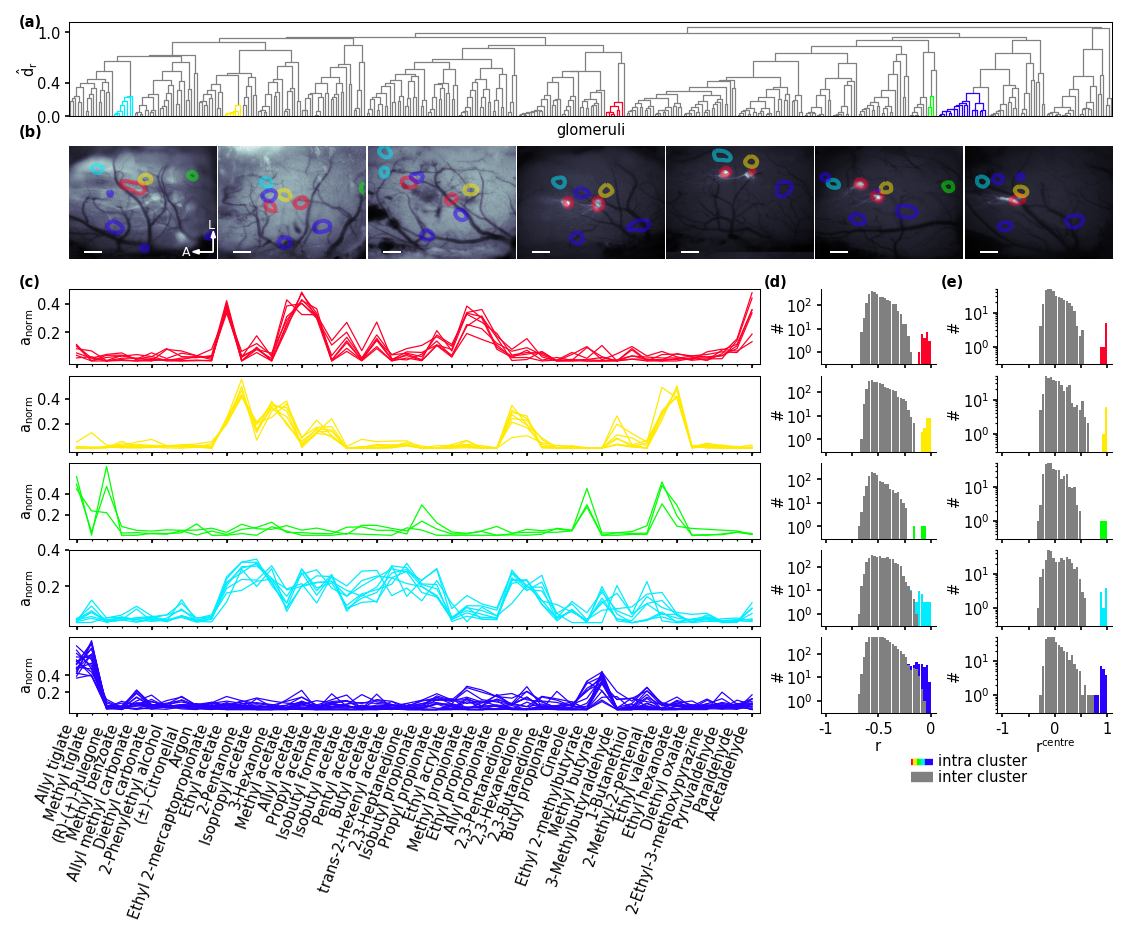

In [18]:
cluster = [200, 172, 256, 254, 278]
num_cluster = len(cluster)

fig = plt.figure(figsize=fig_dim) #(15,1*(num_cluster+2)))
gs_meta = matplotlib.gridspec.GridSpec(3, 1, bottom=0.5, top = 0.99, left = 0.05, right=0.98, 
                                       height_ratios=[1, 1.5, 0.9*num_cluster], hspace=0.07)
axlegend = fig.add_axes([0.8, 0.45, 0.02, 0.02])

metric = 'correlation'
num_animals = len(animals)
num_stim = len(ts.label_stimuli)
clust_colors = {clust: plt.cm.gist_rainbow(1.*cluster.index(clust)/num_cluster) for clust in cluster}

# plot dendrogram
ax = fig.add_subplot(gs_meta[0])
top = gs_meta[0].get_position(fig).corners()[1,1]
fig.text(0.005, top, '(a)', fontweight='bold', fontsize=global_fs, ha='left', va='center')
lw = matplotlib.rcParams['lines.linewidth']
matplotlib.rcParams['lines.linewidth'] = 0.6
d = dendrogram(link, link_color_func = color_clusters(cluster, clust_colors), count_sort='descending')
matplotlib.rcParams['lines.linewidth'] = lw
ax.set_xticks([])
ax.set_yticks([0,0.4,1])
ax.set_ylabel('$\hat{d}_{r}$', labelpad=-1)
ax.set_xlabel('glomeruli', labelpad=3)

# plot locations
gs = matplotlib.gridspec.GridSpecFromSubplotSpec(1, num_animals, gs_meta[1], wspace=0.01)
top = gs_meta[1].get_position(fig).corners()[1,1]
fig.text(0.005, top, '(b)', fontweight='bold', fontsize=global_fs, ha='left', va='center')
axbase = {animal: fig.add_subplot(gs[0,ix]) for ix, animal in enumerate(animals)}
ax = plot_location(ts_normed, link, cluster, bg_dict, axbase, clust_colors, face=False)
#plot_location(ts_normed, link, [cluster[0]], bg_dict, axbase, clust_colors)




# prepare axes for plotting spectra and cluster distances
gs = matplotlib.gridspec.GridSpecFromSubplotSpec(num_cluster, 3, gs_meta[2], hspace=0.15, 
                                                 width_ratios=[6,1,1], wspace=0.2)
# create panel labels
top = gs_meta[2].get_position(fig).corners()[1,1]
fig.text(0.005, top+0.005, '(c)', fontweight='bold', fontsize=global_fs, ha='left', va='center')
left = gs[1].get_position(fig).corners()[1,0]
fig.text(left-0.03, top+0.005, '(d)', fontweight='bold', fontsize=global_fs, ha='right', va='center')
left = gs[2].get_position(fig).corners()[1,0]
fig.text(left-0.03, top+0.005, '(e)', fontweight='bold', fontsize=global_fs, ha='right', va='center')


# plot spectra
axtime = OrderedDict([(clust,fig.add_subplot(gs[ix,0])) for ix, clust in enumerate(cluster)])
lw = matplotlib.rcParams['lines.linewidth']
matplotlib.rcParams['lines.linewidth'] = 0.6
plot_spec(ts_normed, link, cluster, axtime, clust_colors)
matplotlib.rcParams['lines.linewidth'] = lw
for ax in axtime.values():
    ax.set_yticks([0.2,0.4])
    ax.set_ylabel('$a_{norm}$', labelpad=0.5)
    ax.set_xticklabels([])
    ax.set_xticks(np.arange(num_stim), minor=True)
    ax.set_xticks(np.arange(0,num_stim, 5))
axtime.values()[-1].set_xticklabels([cas2name[i].decode('utf-8') for i in ts.label_stimuli], 
                                        rotation='70', ha='right', minor=True)

# plot cluster separation histogramms
for ix, clust in enumerate(cluster):
    cor_inter, cor_intra = inter_intra_dist(ts_normed, link, clust, metric=metric)
    ax1 = fig.add_subplot(gs[ix,1])
    h = ax1.hist([1-cor_inter, [1-cor_intra]], np.linspace(-1,1,41), color=['0.5', clust_colors[clust]], 
            log=True, histtype='barstacked', lw=0, rwidth=0.9, label=['inter', 'intra'])
    ax1.set_ylim((0.3,500))
    ax1.set_yticks([1,10,100])
    ax1.set_ylabel('#', labelpad=0.2)
    ax1.set_xticks([-1,-0.5,0,0.5,1])
    ax1.set_xticklabels([])
    [ax1.spines[i].set_color('none') for i in ['top', 'right']]
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    
    cor_inter, cor_intra = inter_intra_prototypedist(ts_normed, link, clust, metric=metric)
    ax2 = fig.add_subplot(gs[ix,2])
    ax2.hist([1-cor_inter, 1-cor_intra], np.linspace(-1,1,41), color=['0.5',clust_colors[clust]],
            log=True, histtype='barstacked', lw=0, rwidth=0.9)
    ax2.set_ylim((0.3,50))
    ax2.set_yticks([1,10])
    ax2.set_ylabel('#', labelpad=0.2)
    ax2.set_xticks([-1,-0.5,0,0.5,1])
    ax2.set_xticklabels([])
    [ax2.spines[i].set_color('none') for i in ['top', 'right']]
    ax2.yaxis.set_ticks_position('left')
    ax2.xaxis.set_ticks_position('bottom')

ax1.set_xticks([-1,0,1])
ax1.set_xticklabels([-1, -0.5,0,0.5,1])
ax1.set_xlabel('$r$',labelpad=1)
ax2.set_xticks([-1, -0.5,0,0.5,1])
ax2.set_xticklabels([-1, '', 0, '' ,1])
ax2.set_xlabel('$r^{centre}$', labelpad=0.3)

axlegend.set_axis_off()
[axlegend.plot([i,i+1], [0.05,0.05], color = clust_colors[c], lw=3) for i,c in enumerate(cluster)] 
axlegend.plot([0,len(cluster)], [0,0], color = '0.5', lw=5)
axlegend.text(len(cluster)+1.5, 0.05, 'intra cluster', fontsize=global_fs, va='center')
axlegend.text(len(cluster)+1.5, 0, 'inter cluster', fontsize=global_fs, va='center')
axlegend.set_ylim((-0.02,0.07))



In [19]:
savename = os.path.join(toplevelpath, 'glomcentric_code', 'results', 'tunotopy.png')
fig.savefig(savename, bbox_inches='tight', dpi=600)


#### Overview on cas numbers, odorant names and responses

In [20]:
from pandas import DataFrame
cas = ts_normed.label_stimuli
names = [cas2name[n] for n in cas]
df = DataFrame(index=cas, columns=['names'])
df['names'] = names
for clust in cluster:      
    nodes = return_all_childs(link,clust+link.shape[0]+1)
    spec_collection = [ts_normed.matrix_shaped()[:,node] for node in nodes]
    df[clust] = numpy.mean(array(spec_collection), axis=0)
df

,names,200,172,256,254,278
7493-71-2,Allyl tiglate,0.075226,0.010212,0.505649,0.011300,0.527258
6622-76-0,Methyl tiglate,0.020653,0.019344,0.090379,0.056983,0.597648
89-82-7,(R)-(+)-Pulegone,0.016317,0.009751,0.454621,0.012091,0.037660
93-58-3,Methyl benzoate,0.028872,0.021464,0.035615,0.025096,0.026065
35466-83-2,Allyl methyl carbonate,0.014564,0.018136,0.024674,0.032343,0.095063
105-58-8,Diethyl carbonate,0.021117,0.020319,0.024808,0.023064,0.054734
60-12-8,2-Phenylethyl alcohol,0.029317,0.014379,0.026688,0.020171,0.041865
106-23-0,(±)-Citronellal,0.026695,0.015183,0.038089,0.064748,0.059088
7440-37-1,Argon,0.024031,0.016468,0.054374,0.012539,0.032968
19788-49-9,Ethyl 2-mercaptopropionate,0.026798,0.017181,0.036648,0.026388,0.043156


### Fig 5: Tunotopic Neighbours

#### nearest cluster

In [21]:
mor182cor = squareform(pdist(ts_glom._series.T, 'correlation'))[ts_glom.label_objects.index('clust_200')]
order = np.argsort(mor182cor)
for i in order[:20]:
    print ts_glom.label_objects[i], mor182cor[i]

clust_200 0.0
clust_264 0.583623412583
clust_183 0.659903300175
clust_281 0.678874965278
clust_228 0.693626345935
clust_220 0.711990341832
clust_247 0.729448383906
clust_319 0.781269922738
clust_146 0.8031235461
clust_257 0.806887392946
clust_292 0.810388760867
clust_254 0.813366183694
clust_343 0.856168266839
clust_145 0.869663425966
clust_362 0.902150224476
clust_303 0.926649893754
clust_172 0.951839129063
clust_276 0.993166280473
clust_187 1.00815501039
clust_299 1.01430228564


#### plot

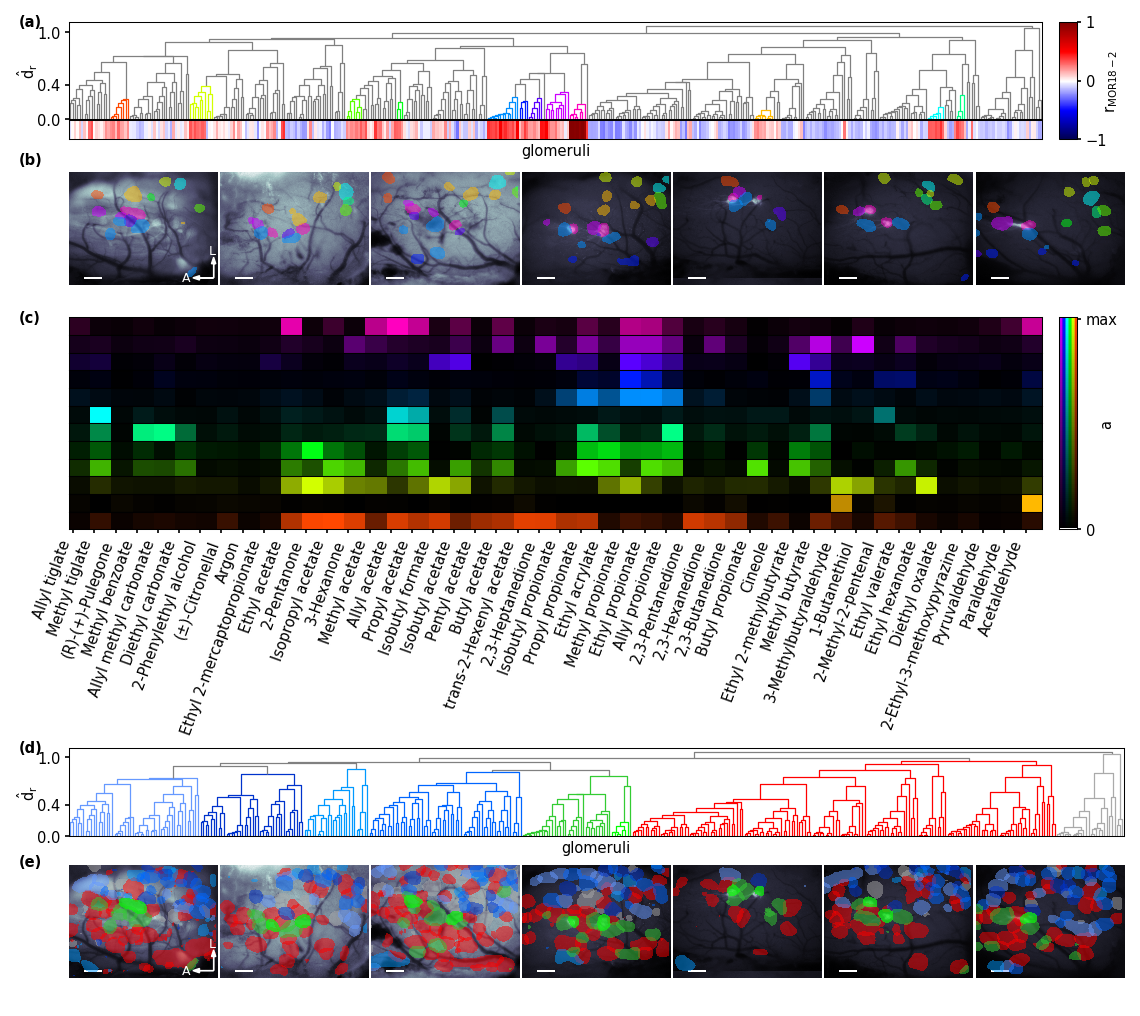

In [22]:
cluster = [200, 292, 257, 228, 264, 183, 281, 220, 247, 319, 146, 254]
num_cluster = len(cluster)

fig = plt.figure(figsize=fig_dim)
gs_meta = matplotlib.gridspec.GridSpec(3, 1, bottom=0.63, top = 0.99, left = 0.05, right=0.99, 
                                       height_ratios=[1,1.4,num_cluster*0.15], hspace=0.04)

num_animals = len(animals)
num_stim = len(ts.label_stimuli)
clust_colors = {clust: plt.cm.gist_rainbow_r(1.*cluster.index(clust)/num_cluster) for clust in cluster}

gs_top = matplotlib.gridspec.GridSpecFromSubplotSpec(2, 3, gs_meta[0], hspace=0.01, height_ratios=[5,1], 
                                                     wspace=0.05, width_ratios=[16.5,0.3,0.5])

# plot dendrogram
ax = fig.add_subplot(gs_top[0,0])
top = gs_meta[0].get_position(fig).corners()[1,1]
fig.text(0.005, top, '(a)', fontweight='bold', fontsize=global_fs, ha='left', va='center')
lw = matplotlib.rcParams['lines.linewidth']
matplotlib.rcParams['lines.linewidth'] = 0.6
d = dendrogram(link, link_color_func = color_clusters(cluster, clust_colors), count_sort='descending')
matplotlib.rcParams['lines.linewidth'] = lw
ax.set_xticks([])
ax.set_yticks([0,0.4,1])
ax.set_ylabel('$\hat{d}_{r}$', labelpad=-1)

# plot MOR18-2 correlation
ax = fig.add_subplot(gs_top[1,0])
im = ax.imshow((1-cor[d['leaves']]).reshape((1,-1)), cmap=plt.cm.seismic,
               interpolation='none', 
               aspect='auto', vmin=-1, vmax=1)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel('glomeruli', labelpad=2)
# colorbar
axbar = fig.add_subplot(gs_top[:,1])
cbar = plt.colorbar(im, cax=axbar)
cbar.set_ticks([-1,0,1])
cbar.set_label('$r_{MOR18-2}$', labelpad=-2)


# plot locations
gs = matplotlib.gridspec.GridSpecFromSubplotSpec(1, num_animals, gs_meta[1,:], wspace=0.02)
top = gs_meta[1].get_position(fig).corners()[1,1]
fig.text(0.005, top-0.01, '(b)', fontweight='bold', fontsize=global_fs, ha='left', va='center')
axbase = {animal: fig.add_subplot(gs[0,ix]) for ix, animal in enumerate(animals)}
plot_location(ts_normed, link, cluster, bg_dict, axbase, clust_colors)


# prepare axes for plotting spectra
gs = matplotlib.gridspec.GridSpecFromSubplotSpec(num_cluster, 3, gs_meta[2], hspace=0, wspace=0.05, 
                                                 width_ratios=[16.5,0.3,0.5])
top = gs_meta[2].get_position(fig).corners()[1,1]
fig.text(0.005, top, '(c)', fontweight='bold', fontsize=global_fs, ha='left', va='center')
axtime = OrderedDict([(clust,fig.add_subplot(gs[ix,0])) for ix, clust in enumerate(cluster)])

# plot spectra
plot_spec(ts_normed, link, cluster, axtime, clust_colors, mean_plot_heatmap)
for ax in axtime.values():
    ax.set_xticklabels([])
    ax.set_xticks([])
ax.set_xticks(np.arange(num_stim)-0.3)
ax.set_xticklabels([cas2name[i].decode('utf-8') for i in ts.label_stimuli], 
                                        rotation='70', ha='right')
ax.xaxis.set_tick_params(direction='out', top='off')
# colorbar
cbar = [] 
for i, clust in enumerate(cluster):  

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('tmp', ['0',clust_colors[clust]])
    cbar.append([cmap(i) for i in np.arange(1,0,-0.01)])

axbar = fig.add_subplot(gs[:,1])
axbar.imshow(np.array(cbar).swapaxes(0,1), interpolation='none', aspect='auto')
axbar.set_xticks([])
axbar.set_yticks([0,100])
axbar.set_yticklabels(['max', '0'])
axbar.yaxis.set_ticks_position('right')
axbar.set_ylabel('a', labelpad=-9)
axbar.yaxis.set_label_position('right')




cluster1 = [200, 387, 391, 389, 394, 383, 400, 402][::-1] #2nd level neigbourhood
#cluster2 = [399, 400, 402] #3rd level neighbourhood

# define axes_layout
h_dend = 2 #heigth of dendrogramms
h_base = 2.5 #heigth of spatial plots
h_time = 0.25 #hieght of timeplots


clust_colors = {200:'#00FF00',
                387:'#33CC33',                
                383:'#6699FF',
                391:'#0066FF',
                389:'#0033CC',
                394:'#0099FF',
                400:'#FF0000',
                402:'#AAAAAA'
                }

# plot first level cluster 
dendrotop = 0.475
gs2 = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[0.6, 1], bottom=0.3, top = dendrotop, 
                                        left = 0.05, right=0.99,  hspace=0.1)
fig.text(0.005, dendrotop, '(d)', fontweight='bold', fontsize=global_fs, ha='left', va='center')
# plot dendrogram of first cluster
ax = fig.add_subplot(gs2[0])

lw = matplotlib.rcParams['lines.linewidth']
matplotlib.rcParams['lines.linewidth'] = 0.6
d = dendrogram(link, link_color_func = color_clusters(cluster1, clust_colors, chex=True), count_sort='descending')
matplotlib.rcParams['lines.linewidth'] = lw
ax.set_xticks([])
ax.set_xlabel('glomeruli', labelpad=2)
ax.set_yticks([0,0.4,1])
ax.set_ylabel('$\hat{d}_{r}$', labelpad=-1)


# plot locations
gs = matplotlib.gridspec.GridSpecFromSubplotSpec(1, num_animals, gs2[1], wspace=0.02)
top = gs2[1].get_position(fig).corners()[1,1]
fig.text(0.005, top-0.01, '(e)', fontweight='bold', fontsize=global_fs, ha='left', va='center')
axbase = {animal: fig.add_subplot(gs[0,ix]) for ix, animal in enumerate(animals)}
plot_location(ts_normed, link, cluster1, bg_dict, axbase, clust_colors, base_thres=0.1)

In [23]:
savename = os.path.join(toplevelpath, 'glomcentric_code', 'results', 'tunotopy_neighborhood.png')
fig.savefig(savename, bbox_inches='tight', dpi=600)

### Distance calculations
#### 1. Evidence for "patchy domain":
* measure the “within patch distance” between any 2 “glomeruli” that are part of the meta-cluster (and part of the same animal) 
* compare that to the distance between any one “glomerulus” that is part of the cluster and one that isn’t (but part of the same animal) and test for significance. If yes then it is justified to state that the glomeruli form a “patchy domain”. 
* I would think that even the pairwise distance between any glomerulus in the “patch” and the closest MOR18-2 – compared to the distance of a non-patch “glomerulus” and the closest MOR18-2 should allow the statement that the patch is centered around the MOR18-2.

##### 1.1 To do: 
1. find out which data structure carries the spectrum: **DONE**. 
2. find out which glomeruli are identified in a meta cluster: **DONE**
3. compute distance between glomeruli in the cluster: **DONE**
4. compute distance between glomeruli outside the cluster: **DONE**
5. Test significance: KS.

##### 1.2 Progress and notes:
* Identified the data structure with the spectra: ts_normed, and figured out how it is organised. 
* Found a few interesting functions: `inter_intra_dist` and `inter_intra_prototype_dist` that were used in Fig. 5 for the histograms. They will come in handy for the desired analysis on top of Fig. 6.
* rewrote `inter_intra_dist` slightly to `extra_intra_dist` and solved the whole thing. 
* added a possibility to provide per-animal statistics.

##### 1.3 Results:
We found that 

#### 2. Evidence for the patch being centered around MOR18-2
The pairwise distance between any glomerulus in the “patch” and the **closest** MOR18-2 – compared to the distance of a non-patch “glomerulus” and the **closest** MOR18-2 should allow the statement that the patch is centered around the MOR18-2.

##### 2.1 Progress and notes
It is tricky to compute the distance to the closest MOR18-2, since this would only be a valid comparison if the glomerulus and MOR18-2 reference are in the same animal. However, it is valid to compute the distance between intra- and extra clusters and the MOR18-2 prototype, just as in Fig. 5.

**Result:** indeed the distance inside the patch to the average MOR18-2 glomerulus is smaller than the distance of most extra-patch glomeruli to the MOR18-2 glomerulus.

#### 3. Glomeruli distant from MOR18-2 but with a certain similarity in tuning are more similar to other glomeruli than MOR18-2
Select putative glomeruli that have a certain similarity higher than a given threshold similarity to MOR18-2 (we use correlation with MOR18-2 > .02, see MS line 455). Then separate those into “far” and “near” glomeruli. For each glomerulus, rank all other glomeruli according to similarity and compare the rank of MOR18-2 glomeruli in this list between the near and far glomeruli. These should be significantly different for all animals.

##### 3.1 To do:
1. compute spatial distance between all glomeruli. - **DONE**
2. 3D-plot: x: spatial distance to MOR18-2; y: tuning distance to MOR18-2; z: tuning rank of MOR18-2?


##### About the data structure

In [24]:
array = ts_normed.shaped2D()
animals = unique([s.split('_')[0] for s in ts_normed.label_objects])
glom_per_animal = {a: [o.split('_')[1] for o in ts_normed.label_objects if o.split('_')[0] == a] for a in animals}
print("ts_normed has {} stimuli and {} objects".format(len(ts_normed.label_stimuli),len(ts_normed.label_objects)))
print("The 2D array has shape {}, therefore stimuli on axis 0 and objects on axis 1".format(array.shape))
print("The 'objects' are glomeruli extracted from {} animals".format(len(animals)))
print("each animal has the following number of glomeruli:")
for k,i in glom_per_animal.items():
    print("{}: {} gloms".format(k, len(i)))

ts_normed has 46 stimuli and 405 objects
The 2D array has shape (46, 405), therefore stimuli on axis 0 and objects on axis 1
The 'objects' are glomeruli extracted from 7 animals
each animal has the following number of glomeruli:
120119: 18 gloms
120121: 56 gloms
111222sph: 87 gloms
120125: 68 gloms
111221sph: 54 gloms
120107: 58 gloms
111210sph: 64 gloms


##### computing distances between extra- and intra-cluster glomeruli

In [25]:
def extra_intra_dist(ts, link, clusters, metric='correlation', animal=None):
    '''
    Pairwise distance between the modes in the branches in `clusters`, and between all other modes.
    ts: timeseries object
    link: linkage (clustering)
    clusters: list of nodes in the linkage
    metric: distance function to apply
    animal: if not None, compute only for modes in this animal.
    '''
    
    member_idx = []
    for cluster_id in clusters:
        member_idx.extend(return_all_childs(link,cluster_id+link.shape[0]+1))
    member_mask = np.zeros(ts.num_objects).astype('bool')
    member_mask[member_idx] = True
    if animal:
        animal_mask = np.zeros(ts.num_objects).astype('bool')
        animal_idx = [i for i,lo in enumerate(ts.label_objects) if lo.split('_')[0] == animal]
        animal_mask[animal_idx] = True
        member_mask = np.logical_and(member_mask, animal_mask)
    dist = pdist(ts._series.T, metric)
    dist_extra = squareform(squareform(dist)[np.logical_not(member_mask)][:,np.logical_not(member_mask)])
    dist_intra = squareform(squareform(dist)[member_mask][:,member_mask])
#    dist_intra = squareform(dist)[member_mask][:,member_mask]
    return dist_extra, dist_intra

KS statistics: v_ks = 0.600, p_ks=1.72e-243


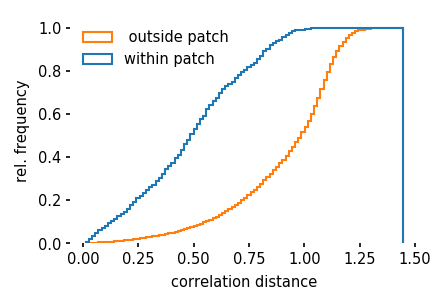

In [179]:
patch_cluster = [200, 292, 257, 228, 264]
extra_dist, intra_dist = extra_intra_dist(ts_normed, link, patch_cluster)
f = plt.figure(figsize=(3,2))
plt.hist([intra_dist, extra_dist], bins=100, normed=True, cumulative=True, histtype='step', label=['within patch', ' outside patch'])
plt.legend(loc='upper left', frameon=False)
ax = plt.gca()
ax.set_xlabel("correlation distance")
ax.set_ylabel("rel. frequency")
ax.set_frame_on(False)
v_ks, p_ks = scipy.stats.ks_2samp(intra_dist, extra_dist)
print("KS statistics: v_ks = {:.3f}, p_ks={:.3g}".format(v_ks, p_ks))

##### Per-animal distances between extra-patch and intra-patch glomeruli

[u'111210sph' u'111221sph' u'111222sph' u'120107' u'120119' u'120121'
 u'120125']
KS statistics: v_ks = 0.716, p_ks=2.56e-05
KS statistics: v_ks = 0.605, p_ks=0.00064
KS statistics: v_ks = 0.574, p_ks=8.04e-07
KS statistics: v_ks = 0.753, p_ks=2.16e-08
KS statistics: v_ks = 0.546, p_ks=0.000132
KS statistics: v_ks = 0.658, p_ks=0.00538
KS statistics: v_ks = 0.812, p_ks=3.32e-13


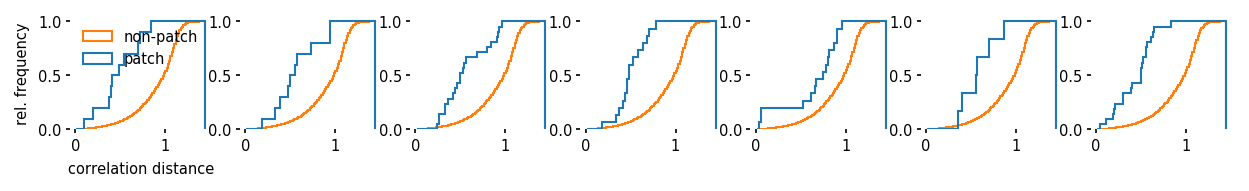

In [180]:
animals = unique([lo.split('_')[0] for lo in ts_normed.label_objects])
print(animals)
f = plt.figure(figsize=(10,1))
gs = mpl.gridspec.GridSpec(1,len(animals))
for i, a in enumerate(animals):
    patch_cluster = [200, 292, 257, 228, 264]
    extra_dist, intra_dist = extra_intra_dist(ts_normed, link, patch_cluster, animal=a)
    ax = f.add_subplot(gs[i])
    ax.hist([intra_dist, extra_dist], bins=100, normed=True, cumulative=True, histtype='step', label=['patch', 'non-patch'])
    if i == 0:
        ax.legend(loc='upper left', frameon=False)
        ax.set_xlabel("correlation distance")
        ax.set_ylabel("rel. frequency")
    ax.set_frame_on(False)
    v_ks, p_ks = scipy.stats.ks_2samp(intra_dist, extra_dist)
    print("KS statistics: v_ks = {:.3f}, p_ks={:.3g}".format(v_ks, p_ks))

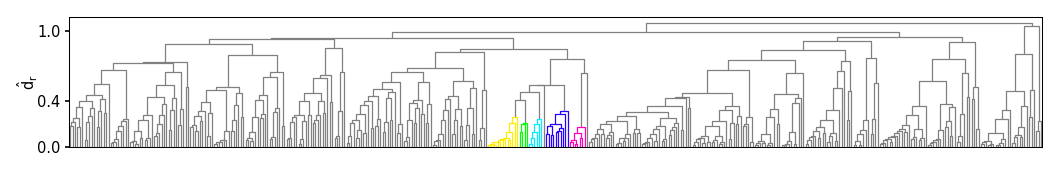

In [28]:
# FOR REFERENCE: These are the clusters taken into account
cluster = [200, 292, 257, 228, 264]
num_cluster = len(cluster)
fig = plt.figure(figsize=fig_dim)
gs_meta = matplotlib.gridspec.GridSpec(3, 1, bottom=0.63, top = 0.99, left = 0.05, right=0.99, 
                                       height_ratios=[1,1.4,num_cluster*0.15], hspace=0.04)

num_animals = len(animals)
num_stim = len(ts.label_stimuli)
clust_colors = {clust: plt.cm.gist_rainbow_r(1.*cluster.index(clust)/num_cluster) for clust in cluster}

gs_top = matplotlib.gridspec.GridSpecFromSubplotSpec(2, 3, gs_meta[0], hspace=0.01, height_ratios=[5,1], 
                                                     wspace=0.05, width_ratios=[16.5,0.3,0.5])
# plot dendrogram
ax = fig.add_subplot(gs_top[0,0])
top = gs_meta[0].get_position(fig).corners()[1,1]
lw = matplotlib.rcParams['lines.linewidth']
matplotlib.rcParams['lines.linewidth'] = 0.6
d = dendrogram(link, link_color_func = color_clusters(cluster, clust_colors), count_sort='descending')
matplotlib.rcParams['lines.linewidth'] = lw
ax.set_xticks([])
ax.set_yticks([0,0.4,1])
ax.set_ylabel('$\hat{d}_{r}$', labelpad=-1)

##### MOL18-2 centered-ness

In [171]:
def extra_intra_referencedist(ts, link, clusters, reference_cluster, metric='correlation', prototyping=np.mean, animal=None):
    '''
    Compute the distances of modes within the branches specified in `clusters` to the reference cluster ("intra"),
    and of all other modes to the reference ("extra").
    ts: timeseries object
    link: linkage (clustering)
    reference_cluster: the id of the reference cluster
    metric: distance metric to apply
    prototyping: how to compute the single prototype from all modes in `reference_cluster`
    animal: If not None, consider only nodes in the specified animal.
    '''
    
    member_idx = []
    for cluster_id in clusters:
        member_idx.extend(return_all_childs(link,cluster_id+link.shape[0]+1))
    member_mask = np.zeros(ts.num_objects).astype('bool')
    member_mask[member_idx] = True
    reference_idx = return_all_childs(link,cluster_id+link.shape[0]+1)
    reference_mask = np.zeros(ts.num_objects).astype('bool')
    reference_mask[reference_idx] = True
    if animal:
        animal_mask = np.zeros(ts.num_objects).astype('bool')
        animal_idx = [i for i,lo in enumerate(ts.label_objects) if lo.split('_')[0] == animal]
        animal_mask[animal_idx] = True
        member_mask = np.logical_and(member_mask, animal_mask)
        reference_mask = np.logical_and(reference_mask, animal_mask)
    print("num. glom. in reference: {}".format(sum(reference_mask)))
    prototype = prototyping(ts_normed._series[:,reference_mask],1)
    dist = squareform(pdist(np.hstack([prototype[:,np.newaxis], ts._series]).T, metric))[0,1:]
    dist_inter = dist[np.logical_not(member_mask)]
    dist_intra = dist[member_mask]
    return dist_inter, dist_intra

num. glom. in reference: 13
KS statistics: v_ks = 0.888, p_ks=2.85e-22
average distance within: 0.29 outside 0.97


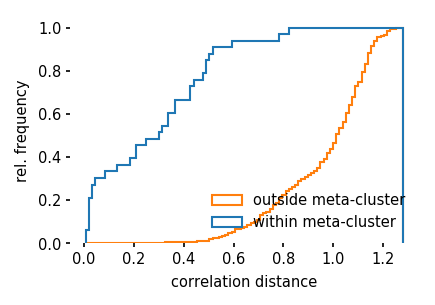

In [181]:
MOR182_cluster = 200
patch_clusters = [292, 257, 228, 264]
extra_dist, intra_dist = extra_intra_referencedist(ts_normed, link, patch_clusters, MOR182_cluster)
f = plt.figure(figsize=(3,2))
plt.hist([intra_dist, extra_dist], bins=100, normed=True, cumulative=True, histtype='step', label=['within meta-cluster', 'outside meta-cluster'])
plt.legend(loc='lower right', frameon=False)
ax = plt.gca()
ax.set_xlabel("correlation distance")
ax.set_ylabel("rel. frequency")
ax.set_frame_on(False)
v_ks, p_ks = scipy.stats.ks_2samp(intra_dist, extra_dist)
print("KS statistics: v_ks = {:.3f}, p_ks={:.3g}".format(v_ks, p_ks))
print("average distance within: {:.2f} outside {:.2f}".format(np.mean(intra_dist), np.mean(extra_dist)))

[u'111210sph' u'111221sph' u'111222sph' u'120107' u'120119' u'120121'
 u'120125']
num. glom. in reference: 2
KS statistics: v_ks = 0.938, p_ks=0.000525
average distance within: 0.19 outside 0.90
num. glom. in reference: 1
KS statistics: v_ks = 0.935, p_ks=0.000549
average distance within: 0.30 outside 0.91
num. glom. in reference: 2
KS statistics: v_ks = 0.783, p_ks=0.000512
average distance within: 0.34 outside 0.93
num. glom. in reference: 1
KS statistics: v_ks = 0.917, p_ks=0.000131
average distance within: 0.36 outside 0.93
num. glom. in reference: 3
KS statistics: v_ks = 0.770, p_ks=0.00227
average distance within: 0.29 outside 0.93
num. glom. in reference: 1
KS statistics: v_ks = 0.945, p_ks=0.00296
average distance within: 0.26 outside 0.91
num. glom. in reference: 3
KS statistics: v_ks = 0.930, p_ks=1.73e-05
average distance within: 0.22 outside 0.93


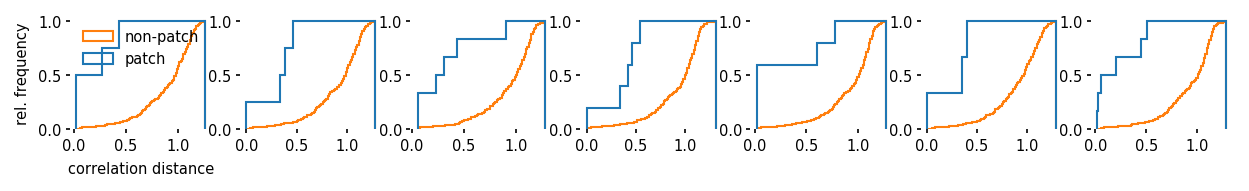

In [182]:
animals = unique([lo.split('_')[0] for lo in ts_normed.label_objects])
print(animals)
MOR182_cluster = 200
patch_clusters = [292, 257, 228, 264]
f = plt.figure(figsize=(10,1))
gs = mpl.gridspec.GridSpec(1,len(animals))
for i,a in enumerate(animals):
    extra_dist, intra_dist = extra_intra_referencedist(ts_normed, link, patch_clusters, MOR182_cluster, animal=a)
    ax = f.add_subplot(gs[i])
    ax.hist([intra_dist, extra_dist], bins=100, normed=True, cumulative=True, histtype='step', label=['patch', 'non-patch'])
    if i < 1:
        ax.legend(frameon=False)
        ax.set_xlabel("correlation distance")
        ax.set_ylabel("rel. frequency")
    ax.set_frame_on(False)
    v_ks, p_ks = scipy.stats.ks_2samp(intra_dist, extra_dist)
    print("KS statistics: v_ks = {:.3f}, p_ks={:.3g}".format(v_ks, p_ks))
    print("average distance within: {:.2f} outside {:.2f}".format(np.mean(intra_dist), np.mean(extra_dist)))


##### Most similar glomerulus  that are near to MOR18-2 

In [32]:
# spatial locations of glomeruli: peaks in the modes
from skimage.feature import peak_local_max
from itertools import compress
peaks = []
for i in range(ts_normed.base.shaped2D().shape[0]):
    peaks.append(peak_local_max(ts.base.shaped2D()[i,:,:], threshold_abs=0.7, min_distance=4))
len(peaks)    


405

In [145]:
#now need to compute a distance matrix between all peaks, using the closest peak in the cases where there are multiple.
from itertools import product
spatial_distmat = np.zeros((len(peaks), len(peaks)))
for i,p1 in enumerate(peaks):
    for j, p2 in enumerate(peaks):
        if (len(p1) < 1) or (len(p2) < 1):
            spatial_distmat[i,j] = np.nan
        else:
            spatial_distmat[i,j] = np.min([np.linalg.norm(pp2 - pp1) for pp1,pp2 in product(p1, p2)])
            
pixel_size = 1.63/1344.*8. *1000. #µm
spatial_distmat *= pixel_size
pixel_size

9.702380952380953

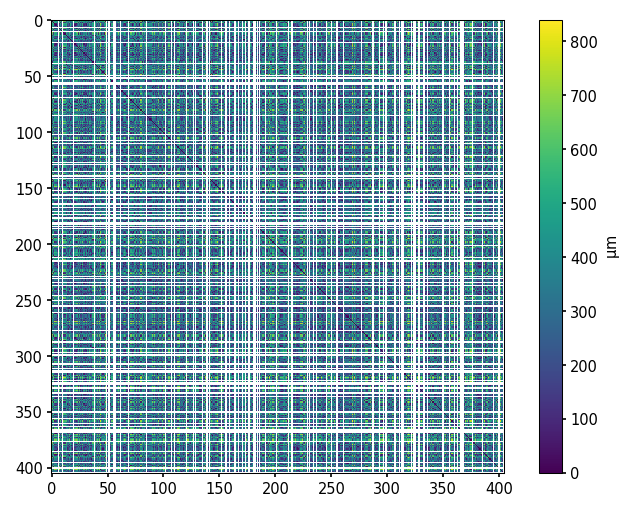

In [146]:
plt.imshow(spatial_distmat)
plt.colorbar(label="$\mu$m")

In [147]:
cluster_id = 200
MOR182gloms = return_all_childs(link,cluster_id+link.shape[0]+1)
print(MOR182gloms)
#for ind in MOR182gloms:
#    plt.figure()
#    plt.imshow(ts_normed.base.shaped2D()[ind])

[278, 15, 112, 132, 243, 326, 392]


In [148]:
tuning_distmat = squareform(pdist(ts._series.T, 'correlation'))

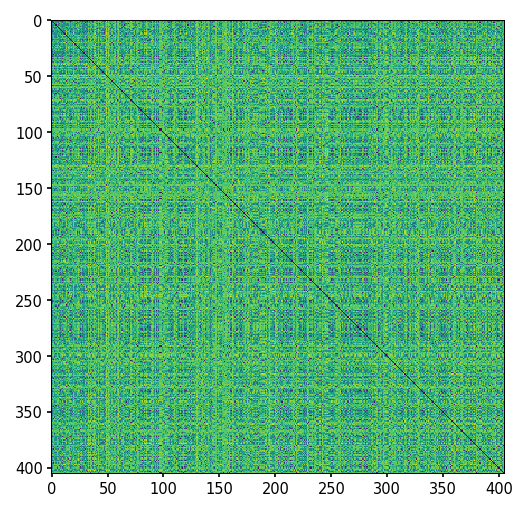

In [149]:
plt.imshow(tuning_distmat)

In [150]:
a_mask_dict = {}
for a in animals:
    animal_idx = [i for i,lo in enumerate(ts_normed.label_objects) if lo.split('_')[0] == a]
    animal_mask = animal_mask = np.zeros(ts_normed.num_objects).astype('bool')
    animal_mask[animal_idx] = True
    a_mask_dict[a] = animal_mask

cluster_id = 200
member_idx = return_all_childs(link,cluster_id+link.shape[0]+1)
member_mask = np.zeros(ts.num_objects).astype('bool')
member_mask[member_idx] = True

t_s_r = [] #tuning distance to MOR18-2, spatial distance, rank of MOR18-2, tuning distance of most similarly tuned glom to MOR18-2
for i,label in enumerate(ts_normed.label_objects):
    animal = label.split("_")[0]
    a_mask = a_mask_dict[animal]
    rank_offset = np.nonzero(a_mask)[0][0]
    a_member_mask = np.logical_and(a_mask, member_mask)
    assert sum(a_member_mask) == 1
    mor182_ind = np.nonzero(a_member_mask)[0][0]
    t_dist = tuning_distmat[i,mor182_ind]
    s_dist = spatial_distmat[i,mor182_ind]
    t_ranks = np.argsort(tuning_distmat[i,a_mask])
    mor_rank = np.where(t_ranks == (mor182_ind - rank_offset))[0]
    most_similar = t_ranks[1]
    most_similar_d = spatial_distmat[mor182_ind,most_similar + rank_offset]
    assert len(mor_rank) == 1
    t_s_r.append([t_dist, s_dist, mor_rank[0], most_similar_d])
t_s_r = np.array(t_s_r)

t_s_r_onlysimilar = t_s_r[np.nonzero(t_s_r[:,0] < 0.8)]


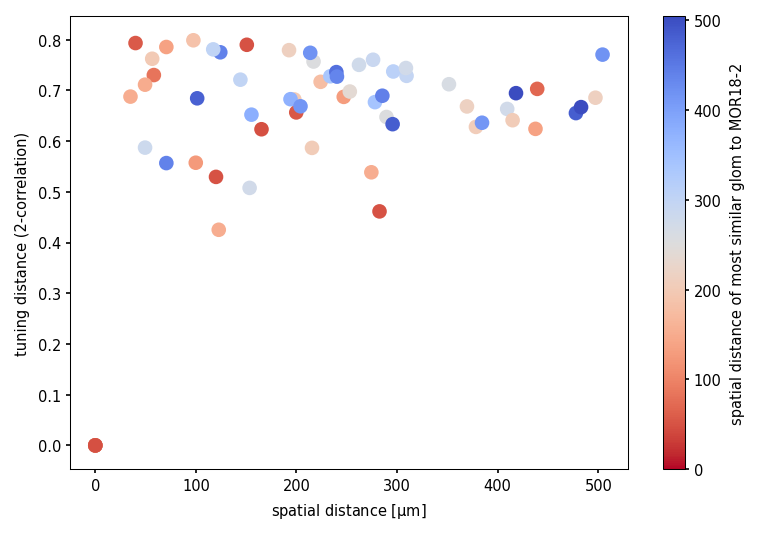

In [151]:
plt.scatter(x=t_s_r_onlysimilar[:,1], y=t_s_r_onlysimilar[:,0], c=t_s_r_onlysimilar[:,3], cmap='coolwarm_r',vmin=0)
ax = gca()
ax.set_xlabel("spatial distance [$\mu$m]")
ax.set_ylabel('tuning distance (2-correlation)')
plt.colorbar(label="spatial distance of most similar glom to MOR18-2")


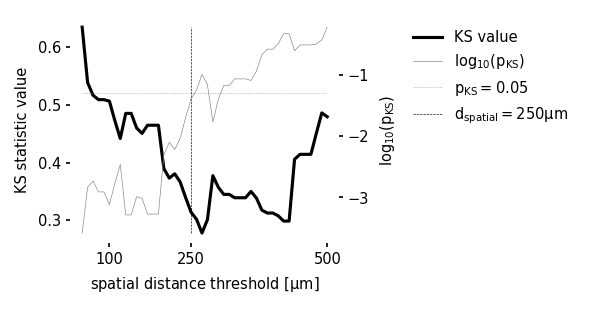

In [270]:
d_thresh = np.arange(50, int(np.nanmax(t_s_r_onlysimilar[:,1]))-10, 10)
res = np.zeros((len(d_thresh), 2))
for i,d in enumerate(d_thresh):
    nears = np.nonzero(t_s_r_onlysimilar[:,1] <= d)[0]
    fars = np.nonzero(t_s_r_onlysimilar[:,1] > d)[0]
    near_sim = t_s_r_onlysimilar[nears,0]
    far_sim = t_s_r_onlysimilar[fars,0]
    v_ks, p_ks = scipy.stats.ks_2samp(near_sim, far_sim)
    res[i,0:2] = [v_ks, p_ks]

f = plt.figure(figsize=(4,2))
gs = plt.GridSpec(1,2, width_ratios=[4,2], wspace=0.3)
ax = f.add_subplot(gs[0])
lvks = ax.plot(d_thresh, res[:,0],"k", label="KS value")
ldth = ax.plot([250, 250],[np.min(res[:,0]), np.max(res[:,0])], linestyle='dashed', color="black", lw=0.3, label="$d_{spatial}=250\mu m$")
ax1 = ax.twinx()
ax.set_xlabel("spatial distance threshold [$\mu$m]")
ax.set_ylabel("KS statistic value")
ax1.set_ylabel("$log_{10}(p_{KS})$")
ax.set_frame_on(False)
ax.set_xticks([100,250,500])
ax1.set_frame_on(False)
axl = f.add_subplot(gs[1], frame_on=False, xticks=[], yticks=[])
lpks = ax1.plot(d_thresh, log10(res[:,1]),"b", label="$log_{10}(p_{KS})$", lw=0.3, color="gray")
lpth = ax1.plot(d_thresh, np.ones_like(d_thresh)*log10(0.05), color="gray", 
                linestyle="dotted", label="$p_{KS} = 0.05$", lw=0.3)
lns = lvks+lpks+lpth+ldth
labs = [l.get_label() for l in lns]
axl.legend(lns, labs, loc="upper left", frameon=False)



In [272]:
savename = os.path.join(toplevelpath, 'glomcentric_code', 'results', 'supplementary_patch_size.png')
f.savefig(savename, bbox_inches='tight', dpi=600)

Tuning similarities for "near" and "far" glomeruli are significantly different, provided that the threshold to separate "near" and "far" glomeruli is small enough. We observed that thresholds between up to 250 µm consistently yield *p*-values smaller than 0.05.


### Supplemental Figure

In [23]:
cluster = json.load(open(cluster_file))[title] if load_cluster else None   

In [24]:
fig_dim = (7.48,9.4)
global_fs= 7 

layout = {   'axes.labelsize': 8,
             'axes.linewidth': .75, 
             'xtick.major.size': 2,     # major tick size in points
             'xtick.minor.size': 1,     # minor tick size in points
             'xtick.labelsize': 8,       # fontsize of the tick labels
             'xtick.major.pad': 2,  
             
             'ytick.major.size': 2,      # major tick size in points
             'ytick.minor.size': 1,     # minor tick size in points
             'ytick.labelsize':8,       # fontsize of the tick labels
             'ytick.major.pad': 2,
             
             'mathtext.default' : 'regular',
             'legend.fontsize': 8
             }

import matplotlib as mpl
for k, v in layout.items():
    mpl.rcParams[k] = v 

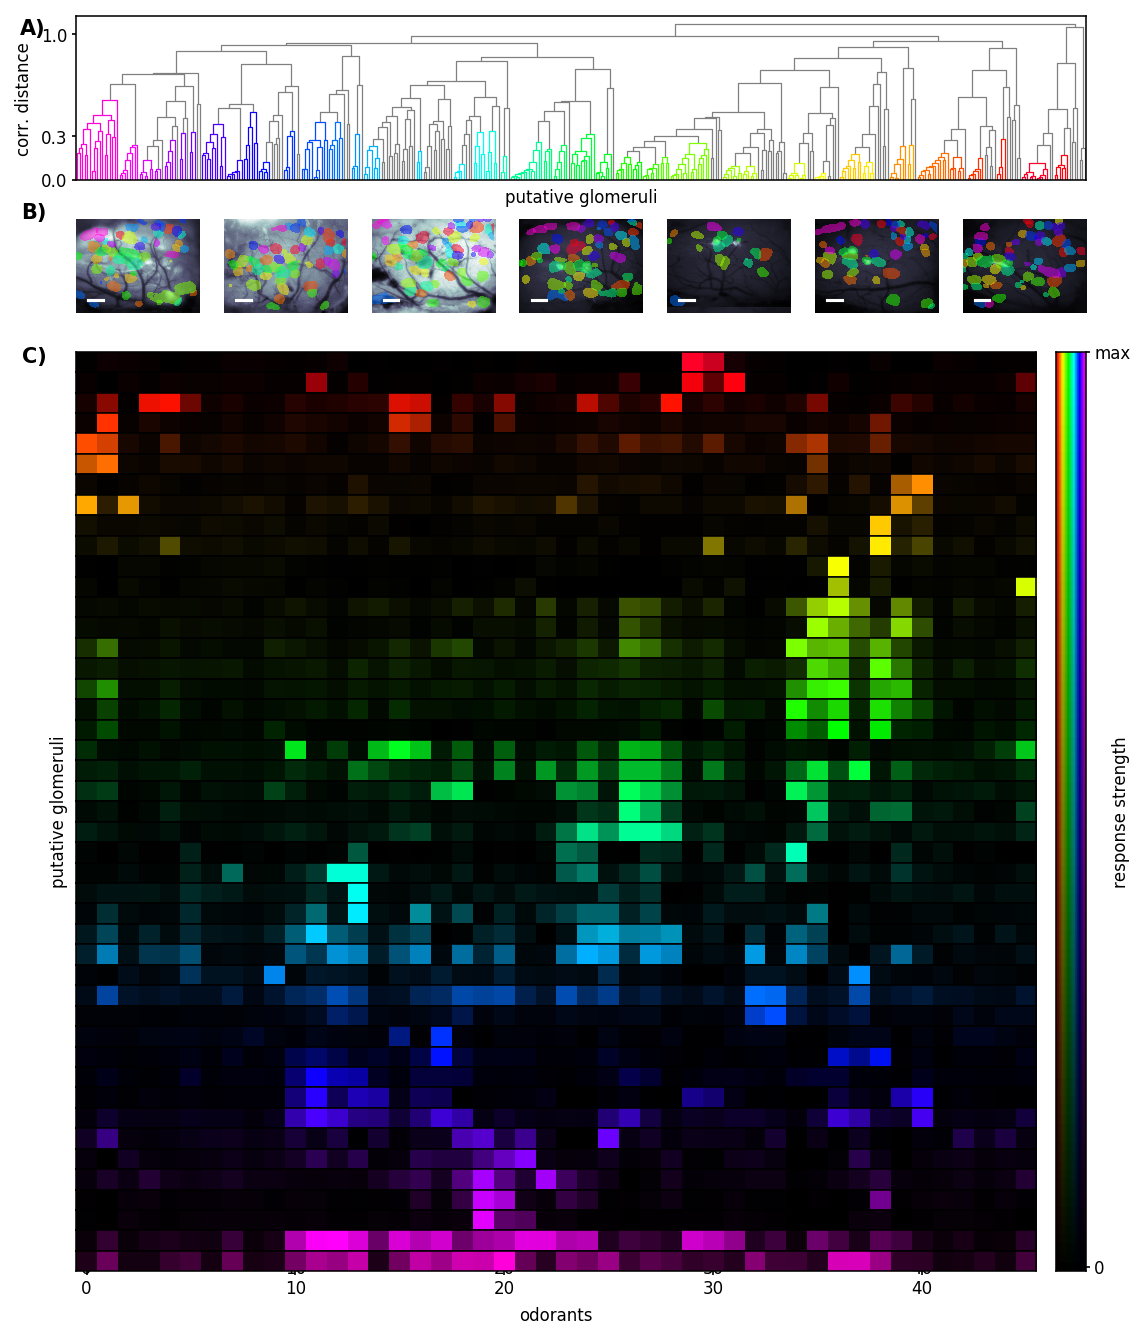

In [26]:
num_cluster = len(cluster)
num_animals = len(animals)
num_stim = len(ts.label_stimuli)
clust_colors = {clust: plt.cm.gist_rainbow(1.*cluster.index(clust)/num_cluster) for clust in cluster}

fig = plt.figure(figsize=fig_dim)
gs_meta = matplotlib.gridspec.GridSpec(3, 1, bottom=0.1, top = 0.99, left = 0.05, right=0.95, height_ratios=[2,2,0.25*num_cluster], hspace=0.01)

# plot dendrogarm
gs_top = matplotlib.gridspec.GridSpecFromSubplotSpec(1,1, gs_meta[0])
ax = fig.add_subplot(gs_top[0])
lw = matplotlib.rcParams['lines.linewidth']
matplotlib.rcParams['lines.linewidth'] = 0.6
d = dendrogram(link, link_color_func = color_clusters(cluster, clust_colors), count_sort='descending')
matplotlib.rcParams['lines.linewidth'] = lw
ax.set_xticks([])
ax.set_yticks([0,0.3,1])
ax.set_ylabel('corr. distance')
ax.set_xlabel('putative glomeruli')
ax.text(-225,1,'A)', weight='bold')

# plot locations
gs = matplotlib.gridspec.GridSpecFromSubplotSpec(1, num_animals, gs_meta[1])
axbase = {animal: fig.add_subplot(gs[0,ix]) for ix, animal in enumerate(animals)}
plot_location(ts_normed, link, cluster, bg_dict, axbase, clust_colors, scalebar=False)
axbase[animals[0]].text(-37.5,0,'B)', weight='bold')

# add scalebar
pixel_size = 1.63/1344. *1000. #µm
len_100 = 100.*pixel_size   # 100 µm
for a in animals:
    bg = bg_dict[a]
    bgs = bg.shape
    # extent=[0,84,64,0])
    scalefacx = 84./bgs[0]
    axbase[a].plot((100*scalefacx,(100+len_100)*scalefacx),(55,55),'w')

# prepare axes for plotting spectra
gs = matplotlib.gridspec.GridSpecFromSubplotSpec(num_cluster,2, gs_meta[2], hspace=0, wspace=0.04, width_ratios=[.97, .03])
axtime = OrderedDict([(clust,fig.add_subplot(gs[ix,0])) for ix, clust in enumerate(cluster)])
plot_spec(ts_normed, link, cluster, axtime, clust_colors, mean_plot_heatmap)
axtime[cluster[0]].text(-3.1,0, 'C)', weight='bold')
axtime[cluster[-1]].set_xlabel("odorants")
axtime[cluster[len(cluster)//2]].set_ylabel("putative glomeruli")

# colorbar
cbar = [] 
for i, clust in enumerate(cluster):  

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('tmp', ['0',clust_colors[clust]])
    cbar.append([cmap(i) for i in np.arange(1,0,-0.01)])

axbar = fig.add_subplot(gs[:,1])
axbar.imshow(np.array(cbar).swapaxes(0,1), interpolation='none', aspect='auto')
axbar.set_xticks([])
axbar.set_yticks([-0.5,99])
axbar.set_yticklabels(['max', '0'])
axbar.yaxis.set_ticks_position('right')
axbar.set_ylabel('response strength', labelpad=-9)
axbar.yaxis.set_label_position('right')

In [27]:
savename = os.path.join(toplevelpath, 'glomcentric_code', 'results', 'Supp_More_tunotopic_neighbors.png')
fig.savefig(savename, bbox_inches='tight', dpi=600)

### Visualization of other cluster combinations of interest
Just for information, not part of the manuscript

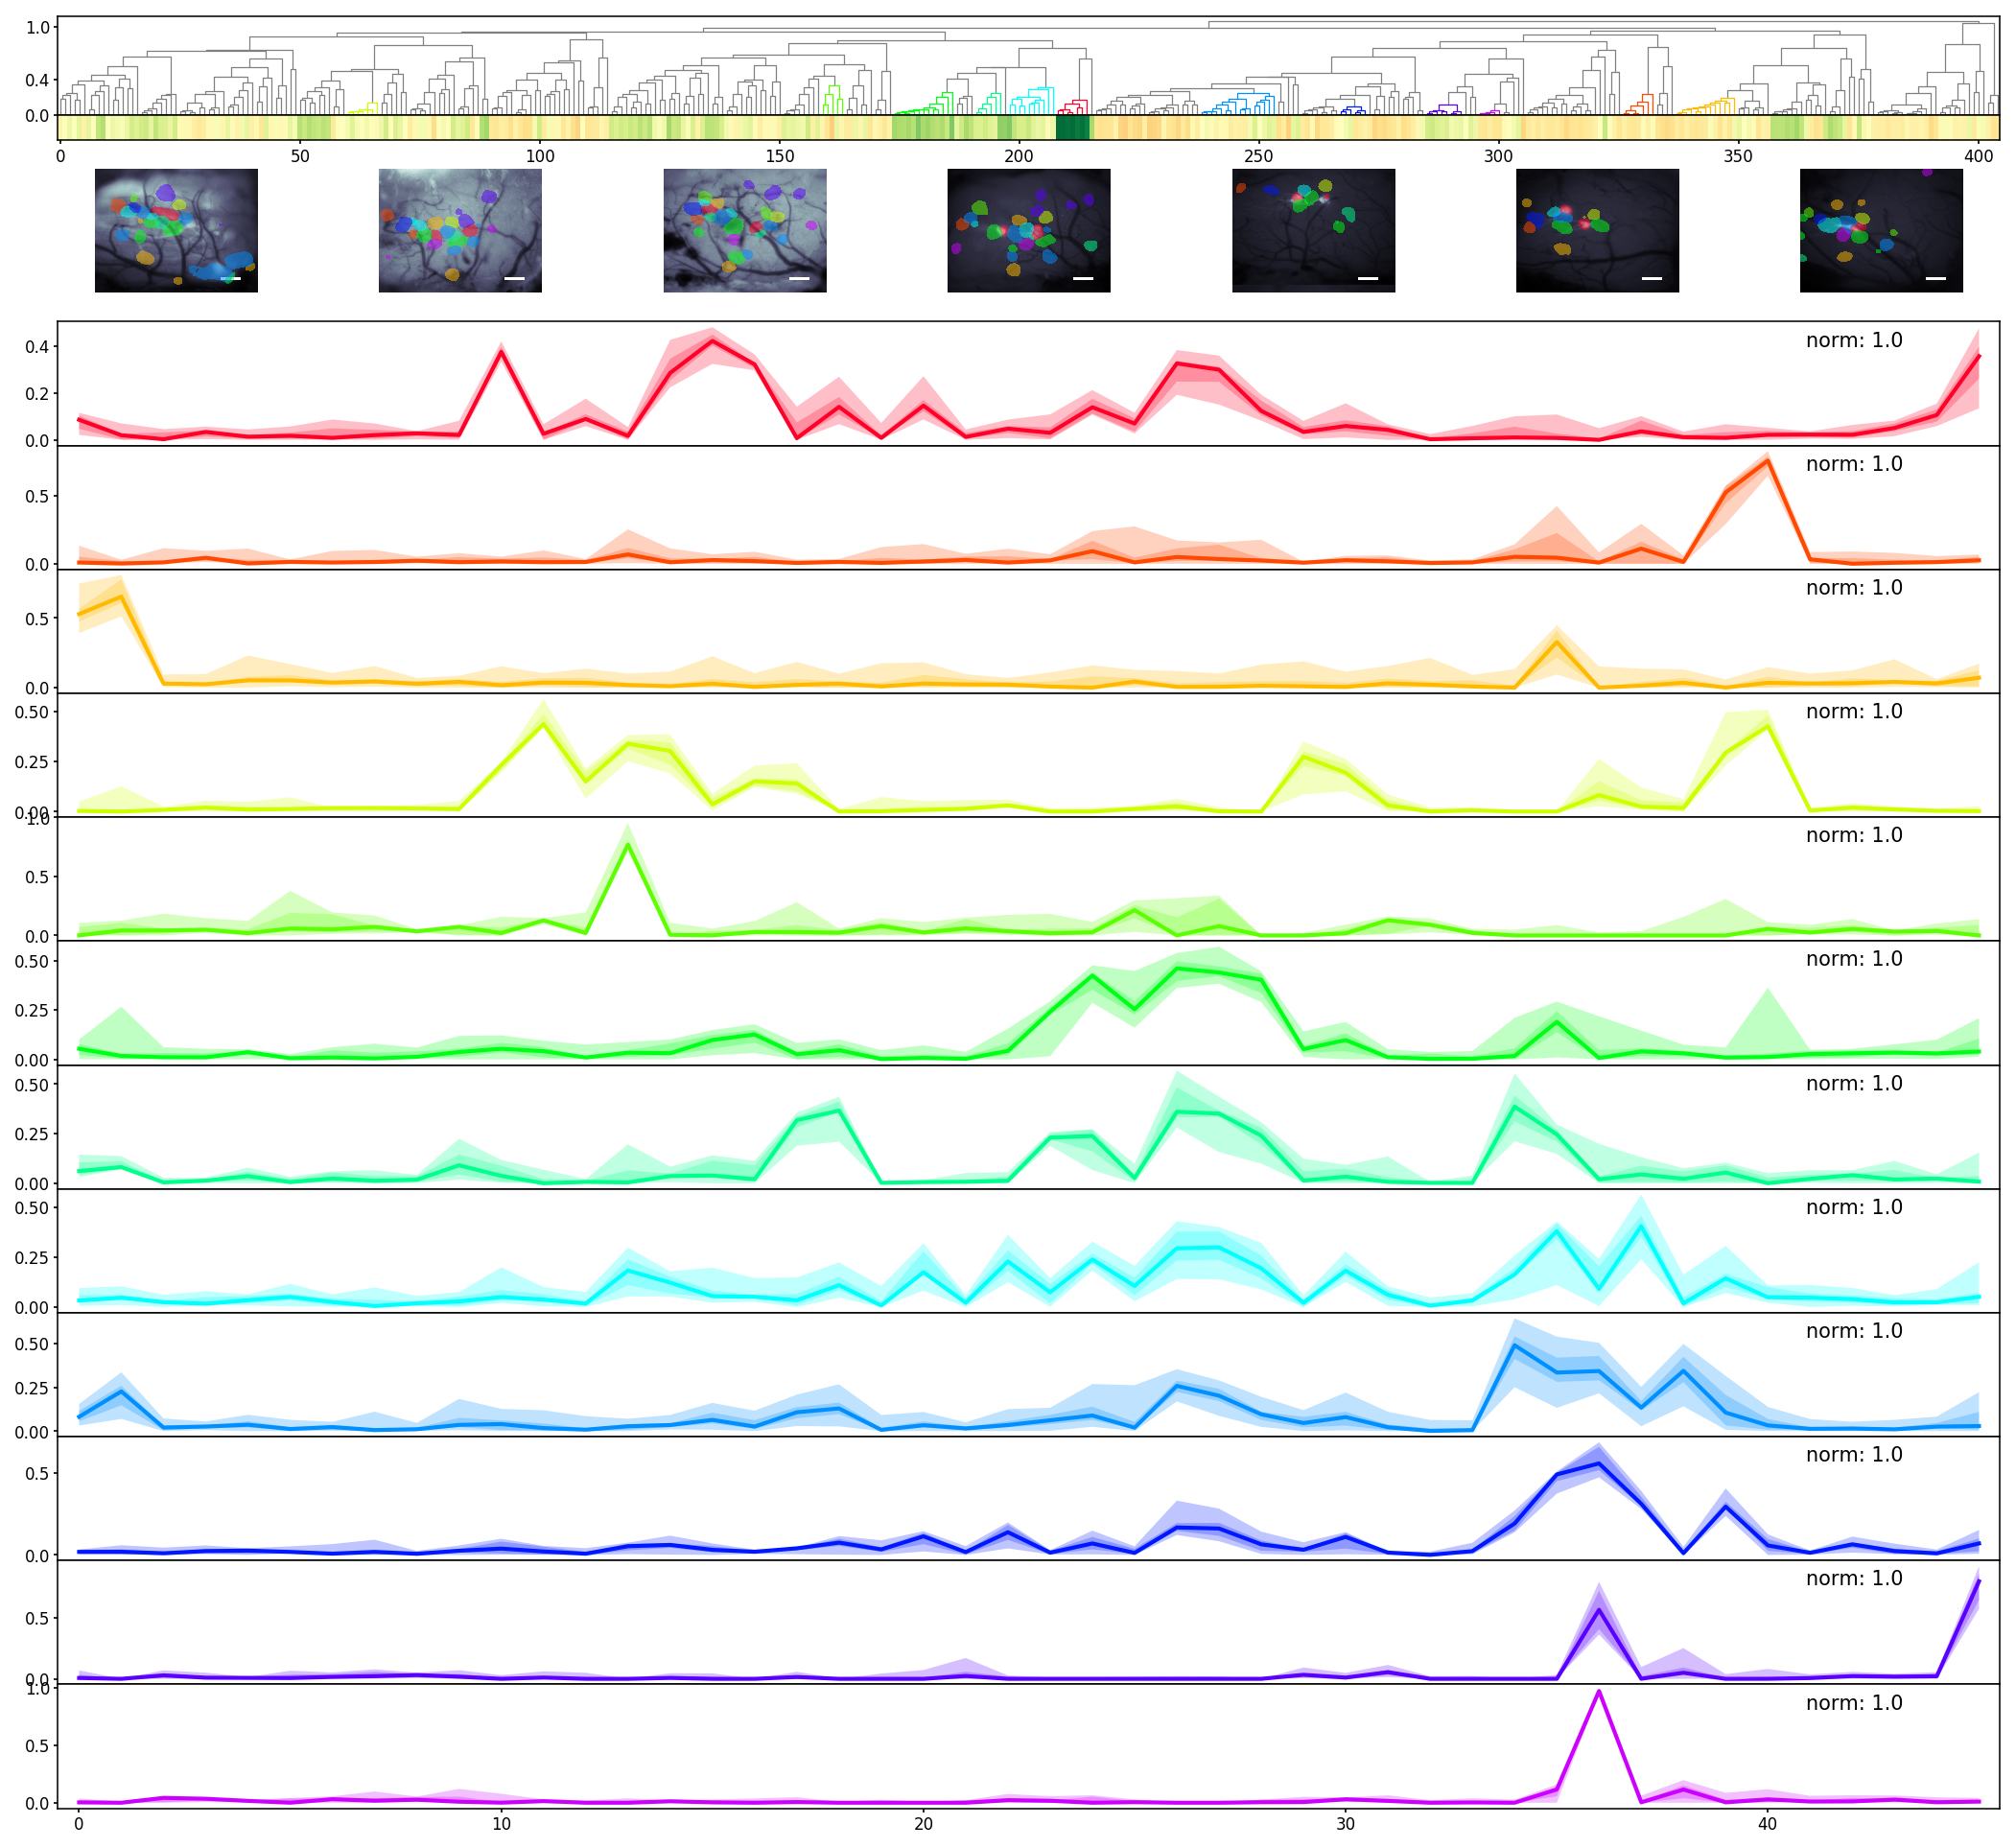

In [27]:
#cluster = [200, 254, 289,204,279,258,220,183,281,257] #all tunotopic close clusters to MOR18-2
#cluster = [200, 163, 247, 254, 197, 319, 281, 362] #good models

cluster = [200,250,211,172,300,264,257,292,261,131,146,62] #all spatial close clusters to MOR18-2

num_cluster = len(cluster)
num_animals = len(animals)
num_stim = len(ts.label_stimuli)
clust_colors = {clust: plt.cm.gist_rainbow(1.*cluster.index(clust)/num_cluster) for clust in cluster}

fig = plt.figure(figsize=(15,1*(num_cluster+2)))
gs_meta = matplotlib.gridspec.GridSpec(3, 1, bottom=0.1, top = 0.99, left = 0.05, right=0.95, height_ratios=[1,1,num_cluster], hspace=0.05)

gs_top = matplotlib.gridspec.GridSpecFromSubplotSpec(2,1, gs_meta[0], hspace=0.01, height_ratios=[4,1])
# plot dendrogram
ax = fig.add_subplot(gs_top[0])
lw = matplotlib.rcParams['lines.linewidth']
matplotlib.rcParams['lines.linewidth'] = 0.6
d = dendrogram(link, link_color_func = color_clusters(cluster, clust_colors), count_sort='descending')
matplotlib.rcParams['lines.linewidth'] = lw
ax.set_xticks([])
ax.set_yticks([0,0.4,1])

# plot MOR18-2 correlation
ax = fig.add_subplot(gs_top[1])
ax.imshow((1-cor[d['leaves']]).reshape((1,-1)), cmap= plt.cm.RdYlGn, interpolation='none', aspect='auto', vmin=-1, vmax=1)
ax.set_yticks([])

# plot locations
gs = matplotlib.gridspec.GridSpecFromSubplotSpec(1, num_animals, gs_meta[1])
axbase = {animal: fig.add_subplot(gs[0,ix]) for ix, animal in enumerate(animals)}
plot_location(ts_normed, link, cluster, bg_dict, axbase, clust_colors)

# prepare axes for plotting spectra
gs = matplotlib.gridspec.GridSpecFromSubplotSpec(num_cluster,1, gs_meta[2], hspace=0)
axtime = OrderedDict([(clust,fig.add_subplot(gs[ix])) for ix, clust in enumerate(cluster)])
plot_spec(ts_normed, link, cluster, axtime, clust_colors, percentile_plot, norm=np.sqrt(np.sum(ts_normed._series**2, 0)))

#savename = os.path.join(toplevelpath, 'glomcentric_code', 'results', '_other_cluster_combinations.png')
#fig.savefig(savename, bbox_inches='tight', dpi=600)